In [1]:
!python --version

Python 3.9.7


## Train initial model

We'll train a model for predicting the duration of a ride

In [2]:
import pandas as pd

In [3]:
df = pd.read_csv('./green_tripdata_2021-01.csv')

C:\Users\alexe\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)

In [5]:
df.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
0,2.0,2021-01-01 00:15:56,2021-01-01 00:19:52,N,1.0,43,151,1.0,1.01,5.5,0.5,0.5,0.00,0.0,NaN,0.3,6.80,2.0,1.0,0.00
1,2.0,2021-01-01 00:25:59,2021-01-01 00:34:44,N,1.0,166,239,1.0,2.53,10.0,0.5,0.5,2.81,0.0,NaN,0.3,16.86,1.0,1.0,2.75
2,2.0,2021-01-01 00:45:57,2021-01-01 00:51:55,N,1.0,41,42,1.0,1.12,6.0,0.5,0.5,1.00,0.0,NaN,0.3,8.30,1.0,1.0,0.00
3,2.0,2020-12-31 23:57:51,2021-01-01 00:04:56,N,1.0,168,75,1.0,1.99,8.0,0.5,0.5,0.00,0.0,NaN,0.3,9.30,2.0,1.0,0.00
4,2.0,2021-01-01 00:16:36,2021-01-01 00:16:40,N,2.0,265,265,3.0,0.00,-52.0,0.0,-0.5,0.00,0.0,NaN,-0.3,-52.80,3.0,1.0,0.00


In [6]:
df.columns

Index(['VendorID', 'lpep_pickup_datetime', 'lpep_dropoff_datetime',
       'store_and_fwd_flag', 'RatecodeID', 'PULocationID', 'DOLocationID',
       'passenger_count', 'trip_distance', 'fare_amount', 'extra', 'mta_tax',
       'tip_amount', 'tolls_amount', 'ehail_fee', 'improvement_surcharge',
       'total_amount', 'payment_type', 'trip_type', 'congestion_surcharge'],
      dtype='object')

In [7]:
df['duration'] = df['lpep_dropoff_datetime'] - df['lpep_pickup_datetime']

In [8]:
df['duration'] = df.duration.apply(lambda td: td.total_seconds() / 60)

In [9]:
(df.trip_distance <= 0).sum()

2553

In [10]:
df = df[df.trip_distance > 0]
df = df[df.trip_type == 2]

In [11]:
df.duration.describe(percentiles=[0.01, 0.95, 0.98, 0.99])

count     800.000000
mean       22.075729
std       105.089009
min         0.000000
1%          0.033333
50%         9.316667
95%        39.288333
98%        61.819667
99%       151.469667
max      1416.100000
Name: duration, dtype: float64

In [12]:
df = df[(df.duration > 1) & (df.duration <= 150)]

In [13]:
df = df.reset_index(drop=True)

In [14]:
df['VendorID'] = df['VendorID'].astype(int)

In [15]:
categorical = ['VendorID', 'PULocationID', 'DOLocationID']
df[categorical] = df[categorical].astype(str)

In [16]:
target = 'duration'
y_train = df[target].values
del df[target]

In [17]:
categorical = ['VendorID']
numerical = ['passenger_count', 'trip_distance']

In [18]:
train_dict = df[categorical + numerical].to_dict(orient='records')

In [19]:
from sklearn.feature_extraction import DictVectorizer

In [20]:
dv = DictVectorizer()

In [21]:
X_train = dv.fit_transform(train_dict)

In [22]:
dv.get_feature_names_out()

array(['VendorID=1', 'VendorID=2', 'passenger_count', 'trip_distance'],
      dtype=object)

In [23]:
from sklearn.linear_model import LinearRegression

In [24]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

In [26]:
y_pred = lr.predict(X_train)

C:\Users\alexe\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\alexe\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


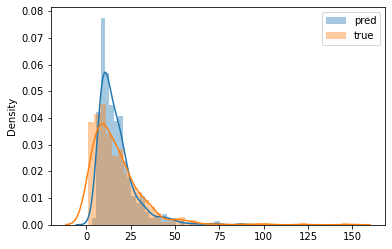

In [27]:
sns.distplot(y_pred, label='pred')
sns.distplot(y_train, label='true')

plt.legend()

In [28]:
from sklearn.metrics import mean_squared_error 

In [29]:
mean_squared_error(y_train, y_pred, squared=False)

10.856837081759885

## Train and validation

Reading both train and validation in the same way

In [30]:
def load_prepare_dataframe(filename):
    df = pd.read_csv(filename)
    
    df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
    
    df['duration'] = df['lpep_dropoff_datetime'] - df['lpep_pickup_datetime']
    df['duration'] = df.duration.apply(lambda td: td.total_seconds() / 60)
    
    df = df[df.trip_distance > 0]
    df = df[df.trip_type == 2]
    
    df = df[(df.duration > 1) & (df.duration <= 150)]
    
    df = df.reset_index(drop=True)
    
    df['VendorID'] = df['VendorID'].astype(int)
    
    categorical = ['VendorID', 'PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [31]:
df_train = load_prepare_dataframe('./green_tripdata_2021-01.csv')
df_val = load_prepare_dataframe('./green_tripdata_2021-02.csv')

C:\Users\alexe\AppData\Local\Temp/ipykernel_19988/2921233024.py:1: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  df_train = load_prepare_dataframe('./green_tripdata_2021-01.csv')


Let's build a model for predicting ride durations under 60 minutes (business requirement)

In [32]:
df_train = df_train[df_train.duration <= 60]
df_val = df_val[df_val.duration <= 60]

Simple model

In [33]:
categorical = ['VendorID']
numerical = ['passenger_count', 'trip_distance']

dv = DictVectorizer()
train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

In [34]:
y_train = df_train['duration'].values
y_val = df_val['duration'].values

lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_val)

In [35]:
mean_squared_error(y_val, y_pred, squared=False)

8.099489069648667

C:\Users\alexe\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\alexe\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


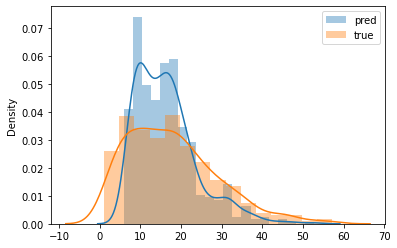

In [36]:
sns.distplot(y_pred, label='pred')
sns.distplot(y_val, label='true')

plt.legend()

Let's add interation features and experiment with models

In [37]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [38]:
categorical = ['VendorID', 'PU_DO']
numerical = ['passenger_count', 'trip_distance']

dv = DictVectorizer()
train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

y_train = df_train['duration'].values
y_val = df_val['duration'].values

In [39]:
from sklearn.linear_model import Lasso

In [40]:
lr = Lasso(alpha=0.01)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

7.899535080103154

## Saving the model

In [41]:
import pickle

In [42]:
with open('model.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [43]:
!ls -lh model.bin

-rw-r--r-- 1 alexey 197121 12K Apr 24 11:13 model.bin
